# Interactias Geo Selected Network

One way of examining the impact of invasive species is to look at all their interactions and the interations those organisms have with each other. This full interaction network gives you an indication of whether a species might be a "keystone" species and therefore have a disproportionatly large impact.

In this step of the evolution of this script it will be adapted to quantify species by their occupancy.

I will harvest species interactions data from GloBI (https://www.globalbioticinteractions.org/) to discover the species that interact with an invasive species.
I will then harvest all the interactions for those species to create two tiers of interactions.
I will then count all the occurences of these in species in the Belgian datacube.
I will then visualize this.

This notebook takes considerable insperation and code from Yikang Li's project on GloBI (https://curiositydata.org/part1_globi_access/).


### For information: This is the list of invasive alien species of Union concern
|A|H|O|
|--|--|--|
|Acacia saligna|Heracleum sosnowskyi|Orconectes virilis|
|Acridotheres tristis|Herpestes javanicus|Oxyura jamaicensis|
|Ailanthus altissima|Humulus scandens|Pacifastacus leniusculus|
|Alopochen aegyptiaca|Hydrocotyle ranunculoides|Parthenium hysterophorus|
|Alternanthera philoxeroides|Impatiens glandulifera|Pennisetum setaceum|
|Andropogon virginicus|Lagarosiphon major|Perccottus glenii|
|Arthurdendyus triangulatus|Lepomis gibbosus|Persicaria perfoliata|
|Asclepias syriaca|Lespedeza cuneata|Plotosus lineatus|
|Baccharis halimifolia|Lithobates catesbeianus|Procambarus clarkii|
|Cabomba caroliniana|Ludwigia grandiflora|Procambarus fallax|
|Callosciurus erythraeus|Ludwigia peploides|Procyon lotor|
|Cardiospermum grandiflorum|Lygodium japonicum|Prosopis juliflora|
|Cortaderia jubata|Lysichiton americanus|Pseudorasbora parva|
|Corvus splendens|Microstegium vimineum|Pueraria montana|
|Ehrharta calycina|Muntiacus reevesi|Salvinia molesta|
|Eichhornia crassipes|Myocastor coypus|Sciurus carolinensis|
|Elodea nuttallii|Myriophyllum aquaticum|Sciurus niger|
|Eriocheir sinensis|Myriophyllum heterophyllum|Tamias sibiricus|
|Gunnera tinctoria|Nasua nasua|Threskiornis aethiopicus|
|Gymnocoronis spilanthoides|Nyctereutes procyonoides|Trachemys scripta|
|Heracleum mantegazzianum|Ondatra zibethicus|Triadica sebifera|
|Heracleum persicum|Orconectes limosus|Vespa velutina|

In [2]:
import sys
print(sys.version)

#Python 3.7.4 (default, Aug 9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
#pygbif 0.3.0

3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]


In [3]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from pygbif import species
from pygbif import occurrences as occ
import sqlite3
from sqlite3 import Error
import pydot
import math

### Setting up some parameters

In [4]:
# There is no point accepting all the species that have more than one record.
# There are too many casual records of plants and birds
thresholdForOccNum = 5
# If you want to exclude an interaction add it here
#interactionsToExclude = "visitsFlowersOf" #If you're not intersted in pollinators this will remove most of them
interactionsToExclude = "interactsWith"    #Many interactions in GloBI do not specify a specific interaction. You can get a cleaner netwot by excluding them
#interactionsToExclude = ""

In [5]:

## Define the country of interest
country  = 'Belgium'

## The occurrence cube has data for each year, but here we aggreagate years to get a more complete measure of occupancy.
## This parameter defines the year from where to consider records for the occupancy
year = 2000

## Define the place to find the data cube for occupancy data
## Currently the cube contains only Belgian data so that is all that can be used
database = r"..\..\data\cube.db" 

## Define the place to find the interaction data
globiDB = r"..\..\createGlobiDB\globi.db"

### Define the taxon for the notebook for which to find all interactions


In [6]:
taxon=input()

Pseudorasbora parva


In [7]:
taxon = taxon.strip()

## Check to see if the taxon exits in GBIF

In [8]:
try:
    #NOTE: The function method name_suggest has a different behavior with regards to the gender of Latin names to name_backbone
    # If name_backbone is given a name in one gender it can still return the best match from the GBIF backbone if that
    # name is spelled as if it was another gender.
    #key = species.name_suggest(q=taxon, limit = 1)
    match = species.name_backbone(name=taxon, limit = 1)
    #print(key)
    
    # if there is no match this is returned form .name_backbone {'confidence': 100, 'matchType': 'NONE', 'synonym': False}
    if match['matchType'] == 'NONE':
        raise ValueError("TAXON NOT FOUND ON GBIF!")
    else:
        key = match['usageKey']
except ValueError as ve:
    print(ve)
    exit(1)




In [9]:
fullScientificName = match['scientificName']
print('The taxon to be studied is ' + fullScientificName)


The taxon to be studied is Pseudorasbora parva (Temminck & Schlegel, 1846)


### Just for information take a look at the interactions that the taxon has

In [10]:
# What are all the types of interactions involving taxon as source taxon?
#data[data['sourceTaxonName'] == taxon]['interactionTypeName'].unique()
try:
    connGlobi = sqlite3.connect(globiDB)
except Error as e:
    print(e)

In [11]:
curGlobi = connGlobi.cursor()
curGlobi.execute("SELECT interactionTypeName, COUNT(interactionTypeName) from globi  WHERE sourceTaxonSpeciesName = ? GROUP BY interactionTypeName;", (taxon,))
sourceInteractions = curGlobi.fetchall()

In [12]:
sourceInteractions

[('eats', 79)]

In [13]:
curGlobi = connGlobi.cursor()
curGlobi.execute("SELECT interactionTypeName, COUNT(interactionTypeName) from globi  WHERE targetTaxonSpeciesName = ? GROUP BY interactionTypeName;", (taxon,))
targetInteractions = curGlobi.fetchall()
targetInteractions

[('eats', 16),
 ('endoparasiteOf', 1),
 ('hasHost', 17),
 ('parasiteOf', 49),
 ('preysOn', 3)]

## Get the primary interation data for the species in question

This is limited to the rank of species because otherwise the network can get very large with rather irrelivent higher taxa.
However, if no interactions are found at the species level it might be worth removing this restriction.

In [14]:
curGlobi = connGlobi.cursor()
#curGlobi.execute("SELECT * from globi  WHERE targetTaxonName = ? and interactionTypeName NOT IN (?);", \
if interactionsToExclude == "":
    curGlobi.execute("SELECT * from globi  WHERE targetTaxonSpeciesName = ?;", \
                 (taxon,))
else:
    curGlobi.execute("SELECT * from globi  WHERE targetTaxonSpeciesName = ? and interactionTypeName NOT IN (?);", \
                 (taxon,interactionsToExclude,))
interactDataTaxon = curGlobi.fetchall()

In [15]:
curGlobi = connGlobi.cursor()
#curGlobi.execute("SELECT * from globi  WHERE sourceTaxonName = ? and interactionTypeName NOT IN (?);", \
if interactionsToExclude == "":
    curGlobi.execute("SELECT * from globi  WHERE sourceTaxonSpeciesName = ?;", \
                 (taxon,))
else:
    curGlobi.execute("SELECT * from globi  WHERE sourceTaxonSpeciesName = ? and interactionTypeName NOT IN (?);", \
                 (taxon,interactionsToExclude,))
sources = curGlobi.fetchall()

In [16]:
interactDataTaxon.extend(sources)
len(interactDataTaxon)

165

In [17]:
# Convert to a Pandas dataframe
interactDataTaxon = pd.DataFrame(interactDataTaxon)

In [18]:
# Add column names
interactDataTaxon
interactDataTaxon.columns = ['sourceTaxonId', \
                                'sourceTaxonIds','sourceTaxonName','sourceTaxonRank','sourceTaxonPathNames', \
                                'sourceTaxonPathIds','sourceTaxonPathRankNames','sourceTaxonSpeciesName','sourceTaxonSpeciesId',\
                                'sourceTaxonGenusName','sourceTaxonGenusId','sourceTaxonFamilyName','sourceTaxonFamilyId',\
                                'sourceTaxonOrderName','sourceTaxonOrderId','sourceTaxonClassName','sourceTaxonClassId',\
                                'sourceTaxonPhylumName','sourceTaxonPhylumId','sourceTaxonKingdomName','sourceTaxonKingdomId',\
                                'sourceId','sourceOccurrenceId','sourceCatalogNumber','sourceBasisOfRecordId',\
                                'sourceBasisOfRecordName','sourceLifeStageId','sourceLifeStageName','sourceBodyPartId',\
                                'sourceBodyPartName','sourcePhysiologicalStateId','sourcePhysiologicalStateName', \
                                'sourceSexId', 'sourceSexName','interactionTypeName',\
                                'interactionTypeId','targetTaxonId','targetTaxonIds','targetTaxonName',\
                                'targetTaxonRank','targetTaxonPathNames','targetTaxonPathIds','targetTaxonPathRankNames',\
                                'targetTaxonSpeciesName','targetTaxonSpeciesId','targetTaxonGenusName','targetTaxonGenusId',\
                                'targetTaxonFamilyName','targetTaxonFamilyId','targetTaxonOrderName','targetTaxonOrderId',\
                                'targetTaxonClassName','targetTaxonClassId','targetTaxonPhylumName','targetTaxonPhylumId',\
                                'targetTaxonKingdomName','targetTaxonKingdomId','targetId','targetOccurrenceId',\
                                'targetCatalogNumber','targetBasisOfRecordId','targetBasisOfRecordName','targetLifeStageId',\
                                'targetLifeStageName','targetBodyPartId','targetBodyPartName','targetPhysiologicalStateId',\
                                'targetPhysiologicalStateName', 'targetSexId', 'targetSexName',\
                                'decimalLatitude','decimalLongitude','localityId',\
                                'localityName','eventDateUnixEpoch','argumentTypeId','referenceCitation',\
                                'referenceDoi','referenceUrl','sourceCitation','sourceNamespace',\
                                'sourceArchiveURI','sourceDOI','sourceLastSeenAtUnixEpoch']

## Get a list of all the primary interacting species

In [19]:
interactingTaxaData = interactDataTaxon.drop_duplicates()

In [20]:
primaryInteractingTaxa = interactingTaxaData['sourceTaxonName'].drop_duplicates()
len(primaryInteractingTaxa)

51

In [21]:
primaryInteractingTaxa = (primaryInteractingTaxa.append(interactingTaxaData['targetTaxonName']).drop_duplicates())
len(primaryInteractingTaxa)

77

In [22]:
primaryInteractingTaxa

0               Archigetes sieboldi
1             Micropterus salmoides
3                 Siniperca chuatsi
5                           no name
7                      Channa argus
8       Chanodichthys erythropterus
9                         Coregonus
14                     Hucho taimen
18             Metorchis orientalis
19                    Urorchis imba
20           Urorchis acheilognathi
21                     Orientotrema
22           Asymphylodora japonica
23                    Asymphylodora
24        Isoparorchis hypselobagri
25               Haplorchis pumilio
26                     Centrocestus
27             Centrocestus armatus
28                   Microparyphium
29        Echinochasmus perfoliatus
30          Echinochasmus japonicus
31                    Echinochasmus
32                      Diplostomum
34            Cyathocotyle prussica
35          Cyathocotyle orientalis
36                    Pseudexorchis
37          Clinostomum complanatum
38         Neidhartia pseudo

## A function to query the globi database

In [23]:
def secondaryDataInGlobi(conn, intaxon):
    cur = conn.cursor()
    if interactionsToExclude == "":
        cur.execute("SELECT * from globi  WHERE (targetTaxonSpeciesName = ? OR sourceTaxonSpeciesName = ?);", \
                 (intaxon,intaxon,))
    else:
        cur.execute("SELECT * from globi where (targetTaxonSpeciesName = ? OR sourceTaxonSpeciesName = ?) and interactionTypeName NOT IN (?);", \
                (intaxon,intaxon,interactionsToExclude,))
    return(cur.fetchall())

## Get all the secondary interactions

In [24]:
try:
    conn = sqlite3.connect(globiDB)
except Error as e:
    print(e)

In [25]:
secondarylist = []

for name in primaryInteractingTaxa:
    temp = secondaryDataInGlobi(conn, name)
    secondarylist.extend(temp)

In [26]:
# Convert to a Pandas dataframe
secondarylist = pd.DataFrame(secondarylist)

In [27]:
secondarylist.columns = ['sourceTaxonId', \
                                'sourceTaxonIds','sourceTaxonName','sourceTaxonRank','sourceTaxonPathNames', \
                                'sourceTaxonPathIds','sourceTaxonPathRankNames','sourceTaxonSpeciesName','sourceTaxonSpeciesId',\
                                'sourceTaxonGenusName','sourceTaxonGenusId','sourceTaxonFamilyName','sourceTaxonFamilyId',\
                                'sourceTaxonOrderName','sourceTaxonOrderId','sourceTaxonClassName','sourceTaxonClassId',\
                                'sourceTaxonPhylumName','sourceTaxonPhylumId','sourceTaxonKingdomName','sourceTaxonKingdomId',\
                                'sourceId','sourceOccurrenceId','sourceCatalogNumber','sourceBasisOfRecordId',\
                                'sourceBasisOfRecordName','sourceLifeStageId','sourceLifeStageName','sourceBodyPartId',\
                                'sourceBodyPartName','sourcePhysiologicalStateId','sourcePhysiologicalStateName',\
                                'sourceSexId', 'sourceSexName', 'interactionTypeName',\
                                'interactionTypeId','targetTaxonId','targetTaxonIds','targetTaxonName',\
                                'targetTaxonRank','targetTaxonPathNames','targetTaxonPathIds','targetTaxonPathRankNames',\
                                'targetTaxonSpeciesName','targetTaxonSpeciesId','targetTaxonGenusName','targetTaxonGenusId',\
                                'targetTaxonFamilyName','targetTaxonFamilyId','targetTaxonOrderName','targetTaxonOrderId',\
                                'targetTaxonClassName','targetTaxonClassId','targetTaxonPhylumName','targetTaxonPhylumId',\
                                'targetTaxonKingdomName','targetTaxonKingdomId','targetId','targetOccurrenceId',\
                                'targetCatalogNumber','targetBasisOfRecordId','targetBasisOfRecordName','targetLifeStageId',\
                                'targetLifeStageName','targetBodyPartId','targetBodyPartName','targetPhysiologicalStateId',\
                                'targetPhysiologicalStateName', 'targetSexId', 'targetSexName', \
                                'decimalLatitude','decimalLongitude','localityId',\
                                'localityName','eventDateUnixEpoch','argumentTypeId','referenceCitation',\
                                'referenceDoi','referenceUrl','sourceCitation','sourceNamespace',\
                                'sourceArchiveURI','sourceDOI','sourceLastSeenAtUnixEpoch']

In [28]:
allInteractionsData = interactingTaxaData.append(secondarylist)

In [29]:
allInteractionsData = allInteractionsData.drop_duplicates()


In [30]:
    cleanInteractDataTaxon = allInteractionsData[['sourceTaxonId', 'sourceTaxonName', 'sourceTaxonSpeciesName', 'sourceTaxonRank',
        'sourceTaxonFamilyName', 'interactionTypeName',
        'targetTaxonName','targetTaxonSpeciesName','targetTaxonRank', 'sourceCitation', 'sourceDOI',
        'sourceTaxonKingdomName','sourceTaxonKingdomId', 'targetTaxonKingdomName','targetTaxonKingdomId'                                        
        ]].dropna(subset=['targetTaxonSpeciesName','sourceTaxonSpeciesName'])

In [31]:
allSourceInteractingTaxa = cleanInteractDataTaxon['sourceTaxonSpeciesName'].drop_duplicates()
allTargetInteractingTaxa = cleanInteractDataTaxon['targetTaxonSpeciesName'].drop_duplicates()

In [32]:
allInteractingTaxa = allSourceInteractingTaxa.append(allTargetInteractingTaxa).drop_duplicates()
allInteractingTaxa.count()

883

In [33]:
allInteractingTaxa.head()

0      Archigetes sieboldi
1    Micropterus salmoides
3        Siniperca chuatsi
5                         
7             Channa argus
dtype: object

In [34]:
# How many different sort of interaction do I have left?
# Checking out all the interaction types
cleanInteractDataTaxon.groupby(cleanInteractDataTaxon['interactionTypeName']).size().sort_values(ascending = False)

interactionTypeName
eats              2073
hasHost           2029
parasiteOf        1170
endoparasiteOf     108
preysOn            105
pathogenOf          14
ectoparasiteOf      10
symbiontOf           2
dtype: int64

### This function takes a name string and checks on GBIF to see if the name exists there.

In [35]:
def speciesExistsInGBIF(name, rank):
    try:
        match = species.name_backbone(name=name, rank=rank, limit = 1)

        # if there is no match this is returned from .name_backbone {'confidence': 100, 'matchType': 'NONE', 'synonym': False}
        if match['matchType'] == 'NONE':
            return False
        else:
            return match
    except ValueError as ve:
        print(ve)
        exit(1)

### Check that the species in question is actually found on GBIF

In [36]:
if(speciesExistsInGBIF(taxon, "species") == False):
    print("##### {0} has not been found on GBIF #####".format(taxon))

### Citation for the GBIF Backbone Taxonomy

In [37]:
from datetime import date
print("GBIF Secretariat (2019). GBIF Backbone Taxonomy. Checklist dataset https://doi.org/10.15468/39omei accessed via GBIF.org on ", date.today())

GBIF Secretariat (2019). GBIF Backbone Taxonomy. Checklist dataset https://doi.org/10.15468/39omei accessed via GBIF.org on  2020-07-05


### Check to see which taxa in the interaction network are found in GBIF and list those ones that are not

In [38]:
taxaFound = {}
kingdom = {}

print('Taxa from GLoBI, but not found in GBIF')
for name in allInteractingTaxa.items():
    GBIFName = speciesExistsInGBIF(name[1], "species")
    if GBIFName == False:
        taxaFound[name[1]] = False
        print(name[1])
    else:
        taxaFound[name[1]] = GBIFName['usageKey']
        kingdom[name[1]] = GBIFName['kingdom']

    

Taxa from GLoBI, but not found in GBIF

Capillaria sinipercae
Siniperca chuatsi rhabdovirus
Aeromonas phage pAh6-C
Aeromonas phage CC2
Aeromonas phage
Apherododerus sayanus


In [39]:
# Convert to a Pandas dataframe
taxaFound = pd.DataFrame.from_dict(taxaFound, orient='index')

In [40]:
len(taxaFound)

883

In [41]:
kingdom

{'Archigetes sieboldi': 'Animalia',
 'Micropterus salmoides': 'Animalia',
 'Siniperca chuatsi': 'Animalia',
 'Channa argus': 'Animalia',
 'Chanodichthys erythropterus': 'Animalia',
 'Hucho taimen': 'Animalia',
 'Metorchis orientalis': 'Animalia',
 'Urorchis imba': 'Animalia',
 'Urorchis acheilognathi': 'Animalia',
 'Asymphylodora japonica': 'Animalia',
 'Isoparorchis hypselobagri': 'Animalia',
 'Haplorchis pumilio': 'Animalia',
 'Centrocestus armatus': 'Animalia',
 'Echinochasmus perfoliatus': 'Animalia',
 'Echinochasmus japonicus': 'Animalia',
 'Cyathocotyle prussica': 'Animalia',
 'Cyathocotyle orientalis': 'Animalia',
 'Clinostomum complanatum': 'Animalia',
 'Neidhartia pseudorasbora': 'Animalia',
 'Clonorchis sinensis': 'Animalia',
 'Liolope copulans': 'Animalia',
 'Metagonimus yokogawai': 'Animalia',
 'Echinochasmus milvi': 'Animalia',
 'Exorchis oviformis': 'Animalia',
 'Pseudocapillaria tomentosa': 'Animalia',
 'Anguillicola crassus': 'Animalia',
 'Gyrodactylus parvae': 'Animali

### This function takes a GBIF species key and counts how many occurences exist in the data cube

In [42]:
def speciesCountInCube(conn, key):
    cur = conn.cursor()
    cur.execute("SELECT COUNT(taxonKey) from (SELECT taxonKey FROM cube WHERE year > ? and taxonKey = ? GROUP BY eea_cell_code)", (year, key,))
    return(cur.fetchall())

### Loop over all the taxa that are in the interaction network and are in GBIF to find the ones that have been found in the country

In [43]:
taxaFoundInCountry = []

try:
    conn = sqlite3.connect(database)
except Error as e:
    print(e)

In [44]:
year

2000

In [45]:
for GBIFtaxon in taxaFound.iterrows():
    GBIFOccCount = speciesCountInCube(conn, GBIFtaxon[1][0])
    print(GBIFtaxon[0])
    if GBIFOccCount[0][0] > thresholdForOccNum and GBIFtaxon[0] != taxon: # The threshold for observations is not greater than one, due to all the casual records
        taxaFoundInCountry.append({'key': GBIFtaxon[1][0], 'species': GBIFtaxon[0], 'count': GBIFOccCount[0][0]})
        print('{0} with key {1} occurs in {2} km squares.'.format(GBIFtaxon[0],GBIFtaxon[1][0],GBIFOccCount[0][0]))
    elif GBIFtaxon[0] == taxon:
        taxaFoundInCountry.append({'key': GBIFtaxon[1][0], 'species': GBIFtaxon[0], 'count': GBIFOccCount[0][0]})
        print('{0} with key {1} occurs in {2} km squares.'.format(GBIFtaxon[0],GBIFtaxon[1][0],GBIFOccCount[0][0]))

Archigetes sieboldi
Micropterus salmoides
Siniperca chuatsi

Channa argus
Chanodichthys erythropterus
Hucho taimen
Metorchis orientalis
Urorchis imba
Urorchis acheilognathi
Asymphylodora japonica
Isoparorchis hypselobagri
Haplorchis pumilio
Centrocestus armatus
Echinochasmus perfoliatus
Echinochasmus japonicus
Cyathocotyle prussica
Cyathocotyle orientalis
Clinostomum complanatum
Neidhartia pseudorasbora
Clonorchis sinensis
Liolope copulans
Metagonimus yokogawai
Echinochasmus milvi
Exorchis oviformis
Pseudocapillaria tomentosa
Anguillicola crassus
Gyrodactylus parvae
Gyrodactylus gobioninum
Dactylogyrus yinwenyingae
Dactylogyrus squameus
Bivaginogyrus obscurus
Dactylogyrus facetus
Pallisentis ussuriense
Pomphorhynchus laevis
Acanthocephalus opsariichthydis
Phalacrocorax carbo
Phalacrocorax carbo with key 2481890 occurs in 13119 km squares.
Philometroides pseudorasbori
Aeromonas hydrophila
Pseudorasbora parva
Pseudorasbora parva with key 2362868 occurs in 960 km squares.
Mycteria america

Melanoides tuberculata
Pangasianodon hypophthalmus
Homo sapiens
Anabas testudineus
Tribolodon hakonensis
Rhodeus uyekii
Rhodeus atremius
Nipponocypris temminckii
Misgurnus anguillicaudatus
Vulpes vulpes
Vulpes vulpes with key 5219243 occurs in 43 km squares.
Nyctereutes procyonoides
Nyctereutes procyonoides with key 2434552 occurs in 31 km squares.
Tachysurus nudiceps
Plecoglossus altivelis
Coreoperca kawamebari
Salangichthys microdon
Squalidus japonicus
Gnathopogon strigatus
Acheilognathus macropterus
Hemibarbus labeo
Leuciscus leuciscus
Leuciscus leuciscus with key 4409641 occurs in 190 km squares.
Leuciscus idus
Leuciscus idus with key 4409643 occurs in 515 km squares.
Squalidus atromaculatus
Pungtungia herzi
Microphysogobio koreensis
Anas platyrhynchos
Anas platyrhynchos with key 9761484 occurs in 14221 km squares.
Anas platyrhyncha domestica
Loricariichthys platymetopon
Ictalurus punctatus
Rhamdia quelen
Clarias batrachus
Hoplosternum littorale
Trachelyopterus galeatus
Potamarius 

Micromesistius poutassou
Micromesistius australis
Eleginus gracilis
Boreogadus saida
Sparus aurata
Parablennius gattorugine
Parablennius gattorugine with key 2395767 occurs in 8 km squares.
Dicentrarchus punctatus
Salaria pavo
Aphanius fasciatus
Engraulis mordax
Engraulis japonicus
Engraulis encrasicolus
Engraulis encrasicolus with key 2414031 occurs in 42 km squares.
Astyris lunata
Engraulis anchoita
Sprattus sprattus
Sprattus sprattus with key 2413452 occurs in 368 km squares.
Sardinops sagax
Sardina pilchardus
Sardina pilchardus with key 2413224 occurs in 16 km squares.
Etrumeus teres
Clupea harengus
Clupea harengus with key 8351946 occurs in 366 km squares.
Trachurus trachurus
Trachurus trachurus with key 5210473 occurs in 228 km squares.
Trachurus symmetricus
Trachurus mediterraneus
Ammodytes hexapterus
Ammodytes americanus
Tautogolabrus adspersus
Lithognathus mormyrus
Symphodus doderleini
Pomatomus saltatrix
Ammodytes tobianus
Ammodytes tobianus with key 2389991 occurs in 341 km 

In [46]:
# Convert to a Pandas dataframe
taxaFoundInCountry = pd.DataFrame(taxaFoundInCountry)    

In [47]:
print("The number of species left in the network is {0}".format(len(taxaFoundInCountry)))

The number of species left in the network is 129


In [48]:
taxaFoundInCountry

,count,key,species
0,13119,2481890,Phalacrocorax carbo
1,960,2362868,Pseudorasbora parva
2,4274,2480726,Pandion haliaetus
3,13,2480446,Haliaeetus leucocephalus
4,1413,2346633,Esox lucius
5,103,2481134,Larus delawarensis
6,6,1446479,Dicrotendipes nervosus
7,747,2362524,Tinca tinca
8,2096,2359706,Rutilus rutilus
9,7,2308543,Limnodrilus hoffmeisteri


## Drawing a network of the interactions

Now that I have a list of all the species in the country I can use this as my nodes list for the network diagram.

In [49]:
#networkx seems to be a leading network tool in Python
import networkx as nx
import matplotlib.pyplot as plt

try:
    import pygraphviz
    from networkx.drawing.nx_agraph import write_dot
    print("using package pygraphviz")
except ImportError:
    try:
        import pydot
        from networkx.drawing.nx_pydot import write_dot
        print("using package pydot")
    except ImportError:
        print()
        print("Both pygraphviz and pydot were not found ")
        print("see  https://networkx.github.io/documentation/latest/reference/drawing.html")
        print()

using package pydot


In [50]:
# Create graphic object
G = nx.DiGraph()

In [51]:
# Match colours to interactions to distinguish them on the graph
colorInteractions = {'interaction':['pollinates', 'mutualistOf', 'eats', 'visitsFlowersOf', 'hasHost', 'parasiteOf', 'pathogenOf'],
        'colour':['r', 'g', 'b', 'y', 'm', 'w', 'c']}  

colorInteractionsDf = pd.DataFrame(colorInteractions)

#len(list(G.nodes))

## A quick look at the interaction data to see if it is what is expected

In [52]:
#cleanInteractDataTaxon.loc[(cleanInteractDataTaxon["sourceTaxonName"] == 'Apis mellifera') & (cleanInteractDataTaxon["targetTaxonName"] == 'Procyon lotor')]
cleanInteractDataTaxon.loc[(cleanInteractDataTaxon["sourceTaxonSpeciesName"] == 'Bombus hortorum')]

,sourceTaxonId,sourceTaxonName,sourceTaxonSpeciesName,sourceTaxonRank,sourceTaxonFamilyName,interactionTypeName,targetTaxonName,targetTaxonSpeciesName,targetTaxonRank,sourceCitation,sourceDOI,sourceTaxonKingdomName,sourceTaxonKingdomId,targetTaxonKingdomName,targetTaxonKingdomId


## Figure out which node has the most records. This is so that the graphic can be scaled.

In [53]:
if len(taxaFoundInCountry) > 0:
    maxRecords = taxaFoundInCountry.max()["count"]
    print(maxRecords)

14421


### Add the nodes to the graph

In [54]:
dictOfNodeSizes = {}

for index, row in taxaFoundInCountry.iterrows():
     # access data using column names
    #print('A: ', row['species'], row['count'], row['key'])
    G.add_node(row['species'], gbifkey=row['key'], occupancy = row['count'])
    #create a list of node sizes scaled for the network visulization
    #The square root ensures that the node area is proportional to the occupancy, rather than the radius
    dictOfNodeSizes[row['species']] = math.sqrt(int(row['count']/maxRecords*100))*10

### Add edges to the graph

In [55]:
# iterate over the interacting species that are in GBIF and in the country with iterrows()
# Find the taxa found in the country that are in the source taxon name of the interation data,
# then add the edge if the target species is in the country too.

taxaFoundInCountry_copy = taxaFoundInCountry.copy()

for index, row in taxaFoundInCountry.iterrows():
    # loop over all the taxa finding if any of them are mentioned in the sourceTaxonName field
    for edge in cleanInteractDataTaxon.iterrows():
        if row['species'] == edge[1]['sourceTaxonSpeciesName']:
            #print('B: ', edge[1]['sourceTaxonName'], edge[1]['targetTaxonName'])
            # Some of the target species will not be in GBIF of in the country, so only add an edge where they are.
            for index2, row2 in taxaFoundInCountry_copy.iterrows():
                #print('E: ', row2['species'], edge[1]['targetTaxonName'])
                if row2['species'] == edge[1]['targetTaxonSpeciesName']: 
                    print('C: ', edge[1]['targetTaxonSpeciesName'], row['species'], edge[1]['interactionTypeName'])
                    G.add_edge(row['species'], edge[1]['targetTaxonSpeciesName'], label = edge[1]['interactionTypeName'])
                    
#len(list(G.nodes))


C:  Pseudorasbora parva Phalacrocorax carbo eats
C:  Anguilla anguilla Phalacrocorax carbo preysOn
C:  Lepomis gibbosus Phalacrocorax carbo preysOn
C:  Silurus glanis Phalacrocorax carbo eats
C:  Silurus glanis Phalacrocorax carbo preysOn
C:  Anguilla anguilla Phalacrocorax carbo eats
C:  Lepomis gibbosus Phalacrocorax carbo preysOn
C:  Silurus glanis Phalacrocorax carbo preysOn
C:  Anguilla anguilla Phalacrocorax carbo eats
C:  Anguilla anguilla Phalacrocorax carbo preysOn
C:  Scomber scombrus Phalacrocorax carbo eats
C:  Scomber scombrus Phalacrocorax carbo eats
C:  Chelon labrosus Phalacrocorax carbo eats
C:  Dicentrarchus labrax Phalacrocorax carbo eats
C:  Anguilla anguilla Phalacrocorax carbo eats
C:  Leuciscus leuciscus Phalacrocorax carbo eats
C:  Gadus morhua Phalacrocorax carbo eats
C:  Zoarces viviparus Phalacrocorax carbo eats
C:  Echiichthys vipera Phalacrocorax carbo eats
C:  Solea solea Phalacrocorax carbo eats
C:  Atherina presbyter Phalacrocorax carbo eats
C:  Pleurone

C:  Perca fluviatilis Phalacrocorax carbo eats
C:  Carassius auratus Phalacrocorax carbo eats
C:  Cyprinus carpio Phalacrocorax carbo eats
C:  Carassius auratus Phalacrocorax carbo eats
C:  Cyprinus carpio Phalacrocorax carbo eats
C:  Pomatoschistus minutus Phalacrocorax carbo eats
C:  Hyperoplus lanceolatus Phalacrocorax carbo eats
C:  Ammodytes tobianus Phalacrocorax carbo eats
C:  Zoarces viviparus Phalacrocorax carbo eats
C:  Sander lucioperca Phalacrocorax carbo eats
C:  Perca fluviatilis Phalacrocorax carbo eats
C:  Gasterosteus aculeatus Phalacrocorax carbo eats
C:  Rutilus rutilus Phalacrocorax carbo eats
C:  Leuciscus idus Phalacrocorax carbo eats
C:  Blicca bjoerkna Phalacrocorax carbo eats
C:  Osmerus eperlanus Phalacrocorax carbo eats
C:  Esox lucius Phalacrocorax carbo eats
C:  Clupea harengus Phalacrocorax carbo eats
C:  Pomatoschistus minutus Phalacrocorax carbo eats
C:  Hyperoplus lanceolatus Phalacrocorax carbo eats
C:  Ammodytes tobianus Phalacrocorax carbo eats
C:  Z

C:  Myoxocephalus scorpius Phalacrocorax carbo eats
C:  Pholis gunnellus Phalacrocorax carbo eats
C:  Gadus morhua Phalacrocorax carbo eats
C:  Myoxocephalus scorpius Phalacrocorax carbo eats
C:  Cyclopterus lumpus Phalacrocorax carbo eats
C:  Pholis gunnellus Phalacrocorax carbo eats
C:  Gadus morhua Phalacrocorax carbo eats
C:  Myoxocephalus scorpius Phalacrocorax carbo eats
C:  Pleuronectes platessa Phalacrocorax carbo eats
C:  Hyas coarctatus Phalacrocorax carbo eats
C:  Clupea harengus Phalacrocorax carbo eats
C:  Pandalus montagui Phalacrocorax carbo eats
C:  Pleuronectes platessa Phalacrocorax carbo eats
C:  Hyas coarctatus Phalacrocorax carbo eats
C:  Pleuronectes platessa Phalacrocorax carbo eats
C:  Limanda limanda Phalacrocorax carbo eats
C:  Hyas coarctatus Phalacrocorax carbo eats
C:  Pleuronectes platessa Phalacrocorax carbo eats
C:  Microstomus kitt Phalacrocorax carbo eats
C:  Limanda limanda Phalacrocorax carbo eats
C:  Gasterosteus aculeatus Phalacrocorax carbo eats
C

C:  Squalius cephalus Phalacrocorax carbo eats
C:  Alburnus alburnus Phalacrocorax carbo eats
C:  Blicca bjoerkna Phalacrocorax carbo eats
C:  Abramis brama Phalacrocorax carbo eats
C:  Rutilus rutilus Phalacrocorax carbo eats
C:  Sander lucioperca Phalacrocorax carbo eats
C:  Perca fluviatilis Phalacrocorax carbo eats
C:  Esox lucius Phalacrocorax carbo eats
C:  Barbus barbus Phalacrocorax carbo eats
C:  Chondrostoma nasus Phalacrocorax carbo eats
C:  Gobio gobio Phalacrocorax carbo eats
C:  Ctenopharyngodon idella Phalacrocorax carbo eats
C:  Scardinius erythrophthalmus Phalacrocorax carbo eats
C:  Cyprinus carpio Phalacrocorax carbo eats
C:  Squalius cephalus Phalacrocorax carbo eats
C:  Alburnus alburnus Phalacrocorax carbo eats
C:  Blicca bjoerkna Phalacrocorax carbo eats
C:  Abramis brama Phalacrocorax carbo eats
C:  Rutilus rutilus Phalacrocorax carbo eats
C:  Abramis brama Phalacrocorax carbo eats
C:  Alburnus alburnus Phalacrocorax carbo eats
C:  Squalius cephalus Phalacrocora

In [56]:
# iterate over rows with iterrows()

# Find the taxa found in the country that are in the target taxon name of the interation data,
# then add the edge if the source species is in the country too.

for index, row in taxaFoundInCountry.iterrows():
    for edge in cleanInteractDataTaxon.iterrows():
        if row['species'] == edge[1]['targetTaxonName']:
            #print('D: ', edge[1]['sourceTaxonName'], edge[1]['targetTaxonName'])
            #G.add_node(edge[1]['sourceTaxonName'], gbifkey=row['key'])
            #dictOfNodeSizes[edge[1]['sourceTaxonName']] = int(row['count']/maxRecords*100)
            for index2, row2 in taxaFoundInCountry.iterrows():
                #print('E: ', row2['species'])
                if row2['species'] == edge[1]['sourceTaxonSpeciesName']: 
                    print('F: ', edge[1]['sourceTaxonSpeciesName'],edge[1]['targetTaxonSpeciesName'],edge[1]['interactionTypeName'])
                    G.add_edge(edge[1]['sourceTaxonSpeciesName'], row2['species'], label = edge[1]['interactionTypeName'])

F:  Haliaeetus leucocephalus Phalacrocorax carbo eats
F:  Haliaeetus leucocephalus Phalacrocorax carbo eats
F:  Haliaeetus leucocephalus Phalacrocorax carbo eats
F:  Haliaeetus leucocephalus Phalacrocorax carbo eats
F:  Haliaeetus leucocephalus Phalacrocorax carbo eats
F:  Haliaeetus leucocephalus Phalacrocorax carbo eats
F:  Haliaeetus leucocephalus Phalacrocorax carbo eats
F:  Phalacrocorax carbo Pseudorasbora parva eats
F:  Phalacrocorax carbo Esox lucius eats
F:  Phalacrocorax carbo Esox lucius eats
F:  Phalacrocorax carbo Esox lucius eats
F:  Phalacrocorax carbo Esox lucius eats
F:  Phalacrocorax carbo Esox lucius eats
F:  Phalacrocorax carbo Esox lucius eats
F:  Phalacrocorax carbo Esox lucius eats
F:  Phalacrocorax carbo Esox lucius eats
F:  Phalacrocorax carbo Esox lucius eats
F:  Phalacrocorax carbo Esox lucius eats
F:  Phalacrocorax carbo Esox lucius eats
F:  Phalacrocorax carbo Esox lucius eats
F:  Phalacrocorax carbo Esox lucius eats
F:  Phalacrocorax carbo Esox lucius eats

F:  Phalacrocorax carbo Scardinius erythrophthalmus eats
F:  Phalacrocorax carbo Scardinius erythrophthalmus eats
F:  Phalacrocorax carbo Scardinius erythrophthalmus eats
F:  Phalacrocorax carbo Scardinius erythrophthalmus eats
F:  Phalacrocorax carbo Scardinius erythrophthalmus eats
F:  Phalacrocorax carbo Scardinius erythrophthalmus eats
F:  Phalacrocorax carbo Scardinius erythrophthalmus eats
F:  Phalacrocorax carbo Scardinius erythrophthalmus eats
F:  Phalacrocorax carbo Scardinius erythrophthalmus eats
F:  Phalacrocorax carbo Scardinius erythrophthalmus eats
F:  Phalacrocorax carbo Scardinius erythrophthalmus eats
F:  Phalacrocorax carbo Scardinius erythrophthalmus eats
F:  Phalacrocorax carbo Scardinius erythrophthalmus eats
F:  Phalacrocorax carbo Salmo salar eats
F:  Phalacrocorax carbo Barbatula barbatula eats
F:  Phalacrocorax carbo Cottus gobio eats
F:  Phalacrocorax carbo Cottus gobio eats
F:  Phalacrocorax carbo Lota lota eats
F:  Phalacrocorax carbo Lota lota eats
F:  Pha

F:  Phalacrocorax carbo Myoxocephalus scorpius eats
F:  Phalacrocorax carbo Myoxocephalus scorpius eats
F:  Phalacrocorax carbo Myoxocephalus scorpius eats
F:  Phalacrocorax carbo Scophthalmus rhombus eats
F:  Phalacrocorax carbo Pleuronectes platessa eats
F:  Phalacrocorax carbo Pleuronectes platessa eats
F:  Phalacrocorax carbo Pleuronectes platessa preysOn
F:  Phalacrocorax carbo Pleuronectes platessa eats
F:  Phalacrocorax carbo Pleuronectes platessa eats
F:  Phalacrocorax carbo Pleuronectes platessa eats
F:  Phalacrocorax carbo Pleuronectes platessa eats
F:  Phalacrocorax carbo Pleuronectes platessa eats
F:  Phalacrocorax carbo Pleuronectes platessa eats
F:  Phalacrocorax carbo Pleuronectes platessa eats
F:  Phalacrocorax carbo Pleuronectes platessa eats
F:  Phalacrocorax carbo Pleuronectes platessa eats
F:  Phalacrocorax carbo Pleuronectes platessa eats
F:  Phalacrocorax carbo Pleuronectes platessa eats
F:  Phalacrocorax carbo Pleuronectes platessa eats
F:  Phalacrocorax carbo Li

F:  Phalacrocorax carbo Clupea harengus eats
F:  Phalacrocorax carbo Clupea harengus eats
F:  Phalacrocorax carbo Clupea harengus eats
F:  Phalacrocorax carbo Clupea harengus eats
F:  Phalacrocorax carbo Clupea harengus eats
F:  Phalacrocorax carbo Clupea harengus eats
F:  Phalacrocorax carbo Trachurus trachurus eats
F:  Phalacrocorax carbo Trachurus trachurus eats
F:  Phalacrocorax carbo Trachurus trachurus eats
F:  Phalacrocorax carbo Trachurus trachurus eats
F:  Phalacrocorax carbo Ammodytes tobianus eats
F:  Phalacrocorax carbo Ammodytes tobianus eats
F:  Phalacrocorax carbo Ammodytes tobianus eats
F:  Phalacrocorax carbo Ammodytes tobianus eats
F:  Phalacrocorax carbo Ammodytes tobianus eats
F:  Phalacrocorax carbo Ammodytes tobianus eats
F:  Phalacrocorax carbo Ammodytes tobianus eats
F:  Phalacrocorax carbo Ammodytes tobianus eats
F:  Phalacrocorax carbo Ammodytes tobianus eats
F:  Phalacrocorax carbo Ammodytes tobianus eats
F:  Phalacrocorax carbo Merlangius merlangus preysOn
F

In [57]:
print("Number of nodes = {0}".format(G.number_of_nodes()))
print("Number of edges = {0}".format(G.number_of_edges()))

Number of nodes = 129
Number of edges = 83


In [58]:
len(dictOfNodeSizes)

129

## Remove any nodes that have no edges.
This happens because some of the linking nodes have few supporting observations and so have been weeded out


In [59]:
#for n in G.nodes:
#    if G.degree(n) == 0:
#        G.remove_node(n)
        
G.remove_nodes_from(list(nx.isolates(G)))

In [60]:
len(G.nodes)

81

## Remove any selfloop edges

In [61]:
for e in G.selfloop_edges(data=False):
    G.remove_edge(e[0],e[1])

## Run through the list of nodes again and construct a list of the node sizes in the correct order

In [62]:
listOfNodeSizes = []

for node in G.nodes:
    listOfNodeSizes.append(dictOfNodeSizes[node])

## A network of all the interacting taxa

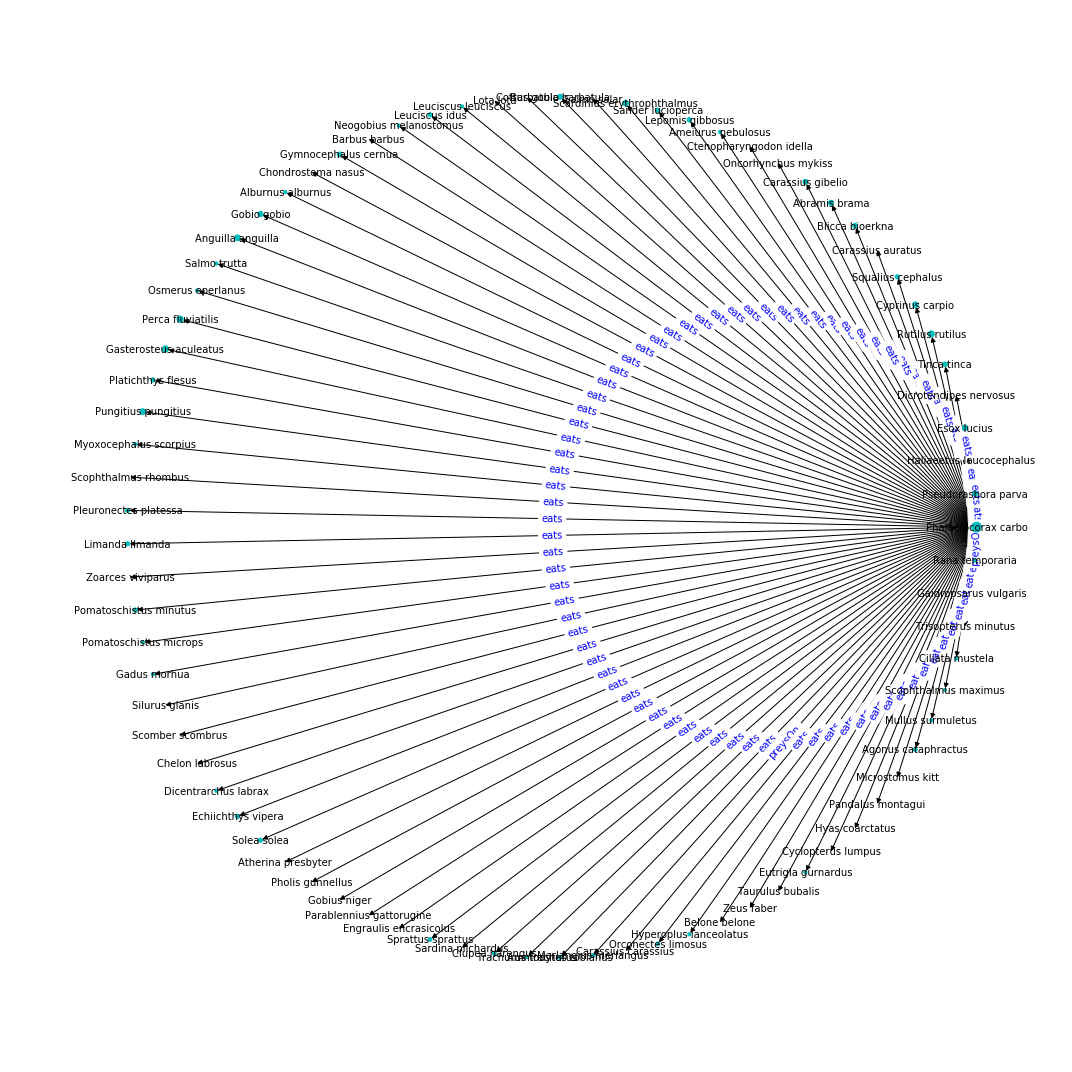

In [63]:
plt.figure(figsize=(15,15))
edge_labels = nx.get_edge_attributes(G,'label')

#pos = nx.spring_layout(G, iterations=50, k=50) 
#pos = nx.spring_layout(G)
#pos = nx.random_layout(G)
pos = nx.circular_layout(G)
#pos = nx.spectral_layout(G)
#pos = nx.shell_layout(G, scale=1)

nodeColors = nx.get_node_attributes(G,'color')

nx.draw_networkx_edge_labels(G,pos, edge_labels = edge_labels, font_size=10, font_color='blue')

#nx.draw_networkx_nodes(G, pos, node_color=nodeColors.values())

nx.draw_networkx(G, pos, with_labels=True, node_size = listOfNodeSizes, node_color='c', alpha= 1, arrows=True, 
                    linewidths=1, font_color="black", font_size=10, style = 'dashed')

plt.axis('off')
plt.tight_layout()
plt.show()

In [64]:
filename = "..\\docs\\"+taxon+country+".html"
with open(filename, "w") as file:
    file.write(" \
<!DOCTYPE html> \
<html> \
<head> \
<script src='../../../GitHub\cytoscape.js\dist\cytoscape.min.js'></script> \
<script src='https://unpkg.com/layout-base/layout-base.js'></script> \
<script src='https://unpkg.com/cose-base/cose-base.js'></script> \
<script src='../../../GitHub\cytoscape.js-cose-bilkent\cytoscape-cose-bilkent.js'></script> \
</head> \
<style>#cy {width: 90%; height: 90%; position: absolute; top: 50px; left: 150px;}\
body {font-family: 'times; font-size: 6px;}\
</style> \
<body> \
<h1><em font-style: italic;>"+taxon+"</em> in "+country+"</h1>")

### Write out the details of the species

In [65]:
with open(filename, "a") as file:
    if len(G.nodes)==0:
        file.write("<p>No interacting species have been found for "+taxon+" in "+country+".<br />") 
    else:
        file.write("<p>Nodes can be moved and if clicked on open a tab with species details<br />") 
        file.write("<p>The target species is red node. <em>Plantae</em> are green, <em>Animalia</em> are blue and everything else is brown<br />") 
        file.write("<p>Node area is proportional to the 1 km<sup>2</sup> occupancy<br />") 
    file.write("<p>All <a href='https://www.globalbioticinteractions.org/'>GloBI</a> interaction records that <em>"+taxon+"</em> has with other taxa</p>")
    

In [66]:
species = G.nodes
#with open(filename, "a") as file:
#    for n in species:
#        file.write("<tr><td><a target='_blank' href=https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+">"+n+"</a></td><td>"+str(dictOfNodeSizes[n])+"</td>\n")

In [67]:
with open(filename, "a") as file: 
    if len(sourceInteractions) != 0:
        file.write("<table><th>Interaction</th><th>number</th>")
        for n in sourceInteractions:
            file.write("<tr><td><a target='_blank' href=https://www.globalbioticinteractions.org/?interactionType="+str(n[0])+"&sourceTaxon="+taxon.replace(" ", "%20")+">"+str(n[0])+"</a></td><td>"+str(n[1])+"</td>\n")
        file.write("</table>") 
    if len(targetInteractions) != 0:
        file.write("<p>All <a href='https://www.globalbioticinteractions.org/'>GloBI</a> interaction records that other taxa have with <em>"+taxon+"</em></p>")
        file.write("<table><th>Interaction</th><th>number</th>")
        for n in targetInteractions:
            file.write("<tr><td><a target='_blank' href=https://www.globalbioticinteractions.org/?interactionType="+str(n[0])+"&targetTaxon="+taxon.replace(" ", "%20")+">"+str(n[0])+"</a></td><td>"+str(n[1])+"</td>\n") 
        file.write("</table>")  

In [68]:
file.close()

In [69]:
with open(filename, "a") as file:
    file.write(" \
<div id='cy'></div> \
<script> \
var cy = cytoscape({ \
  container: document.getElementById('cy'), \n \
  elements: [ \
")

### Write nodes to file

In [70]:
file = open(filename, "a")
for n in species:
    if n == taxon:
        file.write("{ data: { id: '"+n+"', href: 'https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+"', occnum: "+str(dictOfNodeSizes[n])+" }, selectable: true,},\n")
    else:
        file.write("{ data: { id: '"+n+"', kingdom: '"+kingdom[n]+"', href: 'https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+"', occnum: "+str(dictOfNodeSizes[n])+" }, selectable: false,},\n")
file.close()

### Write edges to file

In [71]:
file = open(filename, "a")
for edge in G.edges:
    file.write("{data: {id: '"+edge[0]+edge[1]+"', source: '"+edge[0]+"', target: '"+edge[1]+"', href: 'https://www.globalbioticinteractions.org/?interactionType="+str(nx.get_edge_attributes(G, 'label')[edge])+"&sourceTaxon="+edge[0]+"&targetTaxon="+edge[1]+"', label: '"+nx.get_edge_attributes(G, 'label')[edge]+"'}},\n")
file.close()
    

In [72]:
with open(filename, "a") as file:
    file.write("], \
style: [ \n\
        { \n\
            selector: 'node', \n\
            style: { \n\
                shape: 'circle', \n\
                'background-color': 'yellow', \n\
                label: 'data(id)', \n\
                'text-valign': 'center', \n\
                'font-family': 'helvetica', \n\
                'font-style': 'italic', \n\
                'font-size': '8px', \n\
                'border-width': '0.5', \n\
                'border-color': 'black', \n\
                'width': 'mapData(occnum, 0, 400, 3, 200)', \n\
                'height': 'mapData(occnum, 0, 400, 3, 200)' \n\
            } \n\
        },  \n\
        {  \n\
            selector: 'edge',  \n\
            style: {  \n\
                label: 'data(label)', \n\
                'font-family': 'helvetica', \n\
                'font-size': '6px', \n\
                'color': 'blue', \n\
                'curve-style': 'bezier', \n\
                'target-arrow-shape': 'triangle',  \n\
                'width': '1' \n\
                } \n\
         },  \n\
         {  \n\
              selector: '[kingdom = \"Plantae\"]',   \n\
              css: {  \n\
                'background-color': 'lightgreen'  \n\
                 }  \n\
        }, \n\
        {  \n\
              selector: '[kingdom = \"Animalia\"]',   \n\
              css: {  \n\
                'background-color': 'lightblue'  \n\
                 }  \n\
        }, \n\
        {  \n\
              selector: ':selected',   \n\
              css: {  \n\
                'line-color': 'red',  \n\
                'shape': 'square',  \n\
                'background-color': 'red'  \n\
                 }  \n\
        }], \n\
layout:  { \n\
            name: 'cose-bilkent', padding: 1, animate: true, gravity: 30, animationDuration: 3000 \n\
     } \n\
} \n\
); \n\
")

In [73]:
with open(filename, "a") as file:
    file.write("cy.userZoomingEnabled( true ); \n\
    cy.getElementById('"+taxon+"').select(); \n\
    document.write('<br />Degree of node <em>"+fullScientificName+"</em> = '+cy.getElementById('"+taxon+"').degree()); \n\
    cy.on('tap', 'node', function(){ \n\
        try { // your browser may block popups \n\
              window.open( this.data('href') ); \n\
            } catch(e){ // fall back on url change \n\
        window.location.href = this.data('href'); \n\
    } \n\
}); \n\
    cy.on('tap', 'edge', function(){  \n\
        try { // your browser may block popups  \n\
              window.open( this.data('href') );  \n\
            } catch(e){ // fall back on url change  \n\
        window.location.href = this.data('href'); \n\
    } \n\
}); \n\
</script> \n\
")

In [74]:
with open(filename, "a") as file:
    file.write("</ul> \
        </body> \
        </html>")

In [75]:
file.close()

In [76]:
#with open(filename, "a") as file:
#    file.write("<h2>References</h2><ul>\n")

In [77]:
citations = cleanInteractDataTaxon['sourceCitation'].unique()
#file = open(filename, "a")
for ref in citations:
    print("* ",str(ref))
#    file.write("<li>"+str(ref)+"</li>\n")
#file.close()

*  Sarah E Miller. 9/19/2017. Species associations manually extracted from Benesh, D. P., Lafferty, K. D. and Kuris, A. (2017), A life cycle database for parasitic acanthocephalans, cestodes, and nematodes. Ecology, 98: 882. doi:10.1002/ecy.1680
*  Froese, R. and D. Pauly. Editors. 2019. FishBase. World Wide Web electronic publication. www.fishbase.org, version (08/2019).
*  Giovanni Strona, Maria Lourdes D. Palomares, Nicolas Bailly, Paolo Galli, and Kevin D. Lafferty. 2013. Host range, host ecology, and distribution of more than 11800 fish parasite species. Ecology 94:544. http://dx.doi.org/10.1890/12-1419.1 .
*  Allen Hurlbert. 2017. Avian Diet Database.
*  Sarah E Miller. 4/18/2016. Species associations from Wardeh, M. et al. Database of host-pathogen and related species interactions, and their global distribution. Sci. Data 2:150049 doi: 10.1038/sdata.2015.49 (2015)
*  National Museum of Natural History, Smithsonian Institution IPT RSS Feed
*  http://invertebrates.si.edu/parasites

### For import into Gephi: A nodes and edges file has been replace by the .dot file format

In [78]:
write_dot(G, "..\\docs\\"+taxon+".dot")